In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
# dataset path
# link => https://www3.cs.stonybrook.edu/~cvl/projects/shadow_noisy_label/index.html
zip_file_path = "/content/drive/MyDrive/shadow_dataset/SBU-shadow.zip"
extract_to = '/content/'

shutil.unpack_archive(zip_file_path, extract_to)


In [3]:
# images folder path
train_images_path = '/content/SBU-shadow/SBUTrain4KRecoveredSmall/ShadowImages'
train_mask_path = '/content/SBU-shadow/SBUTrain4KRecoveredSmall/ShadowMasks'

test_images_path = '/content/SBU-shadow/SBU-Test/ShadowImages'
test_mask_path = '/content/SBU-shadow/SBU-Test/ShadowMasks'

In [51]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array

img_size = (128, 128)
# if you can set this =>  (256, 256)

# load image and mask
def load_data(image_path, mask_path, img_size):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_path, img_file))
        img = cv2.resize(img, img_size)
        img = img_to_array(img) / 255.0

        mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

train_images, train_masks = load_data(train_images_path, train_mask_path, img_size)

print(f"Train Images: {train_images.shape}, Train Masks: {train_masks.shape}")


Train Images: (4085, 128, 128, 3), Train Masks: (4085, 128, 128, 1)


In [34]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model3 = unet_model()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 128, 128, 64)   │          1,792 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 128, 128, 64)   │         36,928 │ conv2d_107[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 64, 64, 64)     │              0 │ conv2d_108[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_110 (Conv2D)       │ (None, 64, 64, 128)    │        147,584 │ conv2d_109[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 32, 32, 128)    │              0 │ conv2d_110[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_111 (Conv2D)       │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_112 (Conv2D)       │ (None, 32, 32, 256)    │        590,080 │ conv2d_111[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        131,200 │ conv2d_112[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 64, 64, 256)    │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ conv2d_110[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, 64, 64, 128)    │        295,040 │ concatenate_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 64, 64, 128)    │        147,584 │ conv2d_113[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 64)   │         32,832 │ conv2d_114[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_19            │ (None, 128, 128, 128)  │              0 │ conv2d_transpose_3[0]… │
│ (Concatenate)             │                        │                │ conv2d_108[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 128, 128, 64)   │         73,792 │ concatenate_19[0][0]   │
├──────────────────────

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model3.fit(train_images, train_masks, validation_split=0.2, epochs=5, batch_size=32)


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3380s 33s/step - accuracy: 0.8095 - loss: 0.3998 - val_accuracy: 0.8896 - val_loss: 0.2500
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3412s 33s/step - accuracy: 0.8902 - loss: 0.2348 - val_accuracy: 0.8712 - val_loss: 0.2904
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3384s 33s/step - accuracy: 0.9018 - loss: 0.2117 - val_accuracy: 0.8995 - val_loss: 0.2227
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3554s 34s/step - accuracy: 0.9060 - loss: 0.2013 - val_accuracy: 0.8994 - val_loss: 0.2193
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 3427s 33s/step - accuracy: 0.9120 - loss: 0.1885 - val_accuracy: 0.9006 - val_loss: 0.2234


In [36]:
model3.save('/content/drive/MyDrive/shadow_dataset/shadow_removal_model_v0002.h5')


In [ ]:
from tensorflow.keras.models import load_model

# If you already have a model
model3 = load_model('/content/drive/MyDrive/shadow_dataset/shadow_removal_model_v0002.h5')


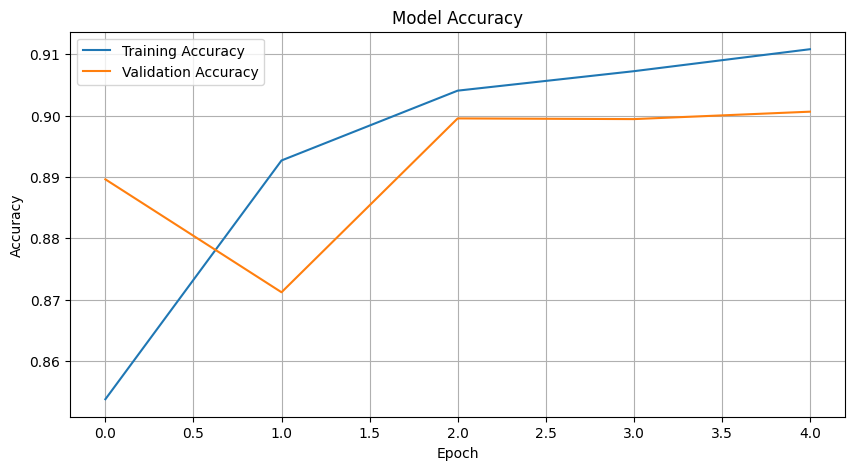

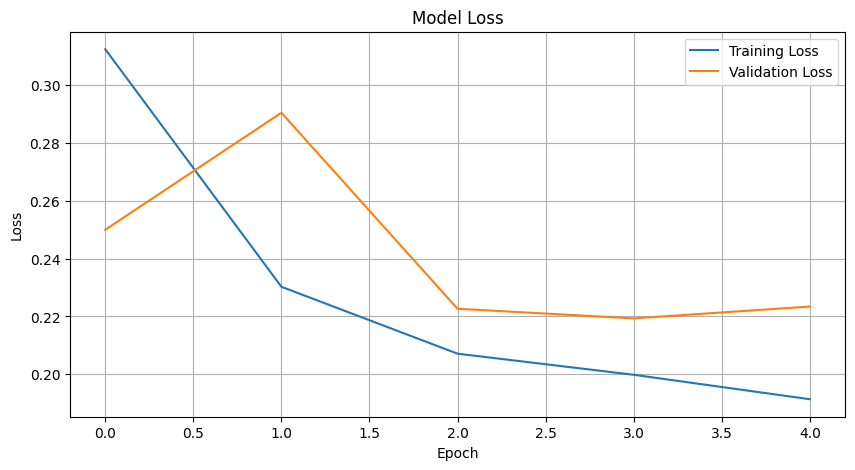

In [54]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


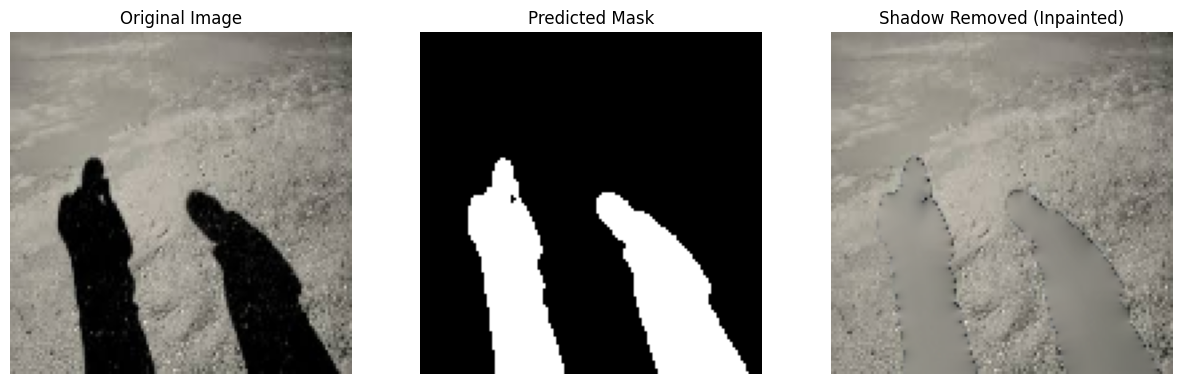

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# preprocess input image
def preprocess_image(image_path, img_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# postprocess output model mask
def postprocess_mask(mask):
    mask = mask[0, :, :, 0]
    mask = (mask > 0.5).astype(np.uint8)
    return mask

# remove shawo from images
def remove_shadow(input_image_path, model, img_size):
    image = preprocess_image(input_image_path, img_size)
    predicted_mask = model.predict(image)
    mask = postprocess_mask(predicted_mask)
    inverted_mask = 1 - mask

    original_image = cv2.imread(input_image_path)
    original_image = cv2.resize(original_image, img_size)

    shadow_removed = original_image * np.expand_dims(inverted_mask, axis=-1)

    inpainted_image = cv2.inpaint(
        shadow_removed.astype(np.uint8),
        (mask * 255).astype(np.uint8),
        inpaintRadius=15,
        flags=cv2.INPAINT_TELEA
    )

    return original_image, mask, inpainted_image

# input image
input_image_path = '/content/download.jpg'
original_image, mask, inpainted_image = remove_shadow(input_image_path, model3, (128, 128))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Shadow Removed (Inpainted)")
plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# save image
output_path = "output_images.png"
plt.savefig(output_path, bbox_inches='tight')

plt.show()

